# Sun - BiSON

Using radial velocity observations from the Birmingham Solar Oscillations Network with p-mode frequencies determined by Broomhall et al. (2009).

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/Broomhall_2009_Table_1.csv')
df.head()

,n,l = 0,l = 1,l = 2,l = 3,l = 4
0,6,972.613 ± 0.002,NaN,NaN,NaN,NaN
1,7,NaN,1185.592 ± 0.004,NaN,NaN,NaN
2,8,1263.162 ± 0.012,1329.629 ± 0.004,1394.680 ± 0.011,NaN,NaN
3,9,1407.481 ± 0.006,1472.836 ± 0.005,1535.861 ± 0.008,1591.575 ± 0.014,NaN
4,10,1548.336 ± 0.007,1612.723 ± 0.007,1674.540 ± 0.008,1729.092 ± 0.016,NaN


In [3]:
df = df.loc[df["l = 0"].notna()]

In [4]:
df["l = 0"] = df["l = 0"].str.split(" ± ")
df.head()

,n,l = 0,l = 1,l = 2,l = 3,l = 4
0,6,"[972.613, 0.002]",NaN,NaN,NaN,NaN
2,8,"[1263.162, 0.012]",1329.629 ± 0.004,1394.680 ± 0.011,NaN,NaN
3,9,"[1407.481, 0.006]",1472.836 ± 0.005,1535.861 ± 0.008,1591.575 ± 0.014,NaN
4,10,"[1548.336, 0.007]",1612.723 ± 0.007,1674.540 ± 0.008,1729.092 ± 0.016,NaN
5,11,"[1686.601, 0.011]",1749.285 ± 0.007,1810.314 ± 0.009,1865.307 ± 0.019,NaN


In [5]:
df[["nu", "nu_err"]] = df["l = 0"].apply(lambda data: pd.Series(data, index=["nu", "nu_err"])).astype(float)

In [6]:
n = df["n"].to_numpy()
nu, nu_err = df[["nu", "nu_err"]].to_numpy().T

In [7]:
import numpy as np
import asterion as ast
from asterion import GlitchModel, Inference
import matplotlib.pyplot as plt

In [8]:
ast.style.use("asterion-light")

In [9]:
nu_max = (3090., 5.)  # in microhertz
delta_nu = (135.2, 5.0)   # in microhertz - inflate uncertainty to deal with low n modes
teff = (4777., 10.)    # in Kelvin

In [10]:
model = GlitchModel(nu_max, delta_nu, teff=teff)

In [11]:
infer = Inference(model, n=n, nu=nu, nu_err=nu_err, seed=10)
infer.prior_predictive()  # <-- check prior is sensible
prior_data = infer.get_data()

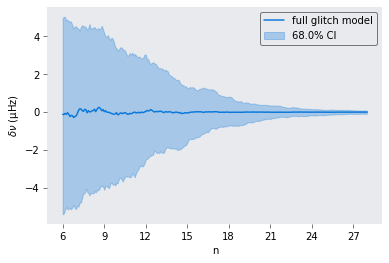

In [12]:
ast.plot_glitch(prior_data, group='prior');

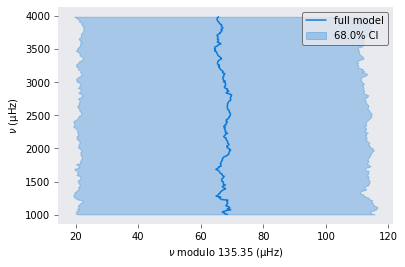

In [13]:
ast.plot_echelle(prior_data, group='prior');

In [14]:
infer.sample(depth=5)
infer.posterior_predictive()

Running nested sampling using the 'multi_ellipsoid' sampler with 50 live points and 50000 maximum samples...


/Users/grd/Repos/matriculate/matriculate_env/lib/python3.9/site-packages/jaxns/nested_sampling.py:293: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  x_dead_new = tree_map(lambda x: x[i_min], state.live_points_X)
/Users/grd/Repos/matriculate/matriculate_env/lib/python3.9/site-packages/jaxns/nested_sampling.py:550: FutureWarning: jax.tree_multimap is deprecated, and will be removed in a future release. Use jax.tree_util.tree_multimap instead.
  live_points_U = tree_multimap(
/Users/grd/Repos/matriculate/matriculate_env/lib/python3.9/site-packages/jax/_src/tree_util.py:205: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
/Users/grd/Repos/matriculate/matriculate_env/lib/python3.9/site-packages/jaxns/nested_sampling.py:553: FutureWarning

Completed in 20.0 seconds.


In [15]:
data = infer.get_data()

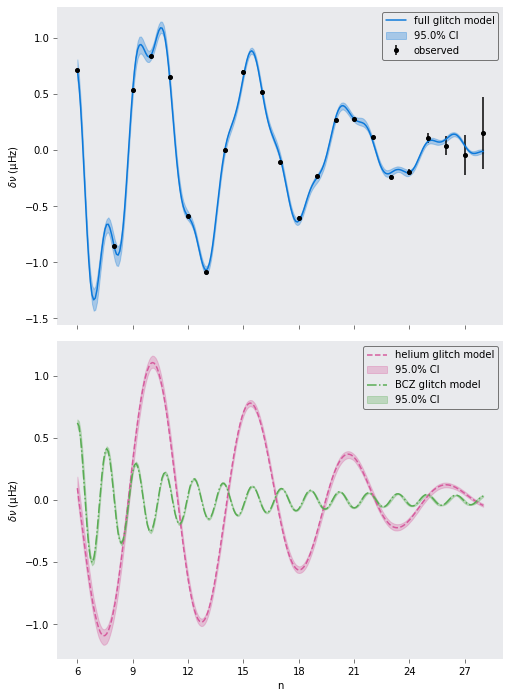

In [16]:
quantiles = [.025, .975]  # <-- 95% confidence interval

_, axes = plt.subplots(2, figsize=(8.0, 12.0), sharex=True, gridspec_kw={"hspace": 0.05})

# FULL GLITCH
ax = axes[0]
ax = ast.plot_glitch(data, quantiles=quantiles, ax=ax)
ax.set_xlabel("")  # Remove xlabel

# GLITCH COMPONANTS
ax = axes[1]
ax = ast.plot_glitch(data, kind='He', quantiles=quantiles, observed=False, ax=ax, color="C1", linestyle="--")
ax = ast.plot_glitch(data, kind='CZ', quantiles=quantiles, observed=False, ax=ax, color="C2", linestyle="-.")

Similarly, we can plot the model on an echelle plot, which folds the mode frequencies on the large frequency separation. By default, it uses the median $\Delta\nu$ from the model, but you can pass `delta_nu` as a keyword argument. Here, the echelle plot does not look right because the model's $\Delta\nu$ is sensitive to the GP. This does not matter because the plot is just a visualisation of the model and its performance.

Text(0, 0.5, '')

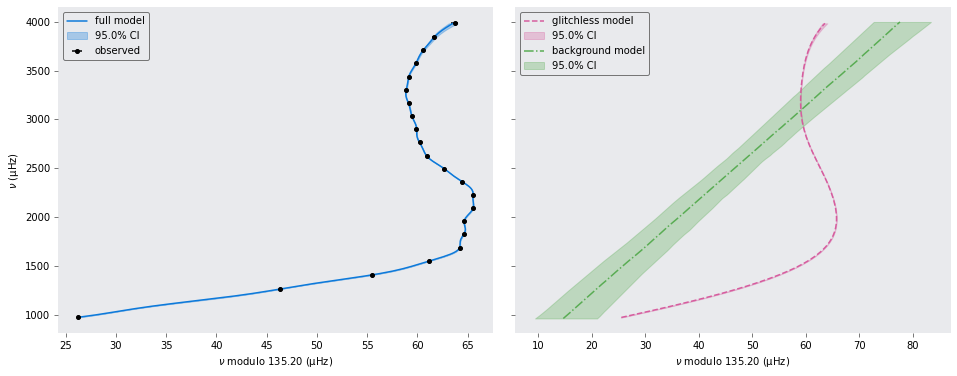

In [17]:
quantiles = [.025, .975]  # <-- 95% confidence interval

_, axes = plt.subplots(ncols=2, figsize=(16.0, 6.0), sharey=True, gridspec_kw={"wspace": 0.05})

# FULL GLITCH
ax = axes[0]
ax = ast.plot_echelle(data, delta_nu=delta_nu[0], quantiles=quantiles, ax=ax)

# GLITCH COMPONANTS
ax = axes[1]
ax = ast.plot_echelle(data, kind='glitchless', delta_nu=delta_nu[0], quantiles=quantiles, observed=False, ax=ax, color="C1", linestyle="--")
ax = ast.plot_echelle(data, kind='background', delta_nu=delta_nu[0], quantiles=quantiles, observed=False, ax=ax, color="C2", linestyle="-.")
ax.set_ylabel("")  # Remove ylabel

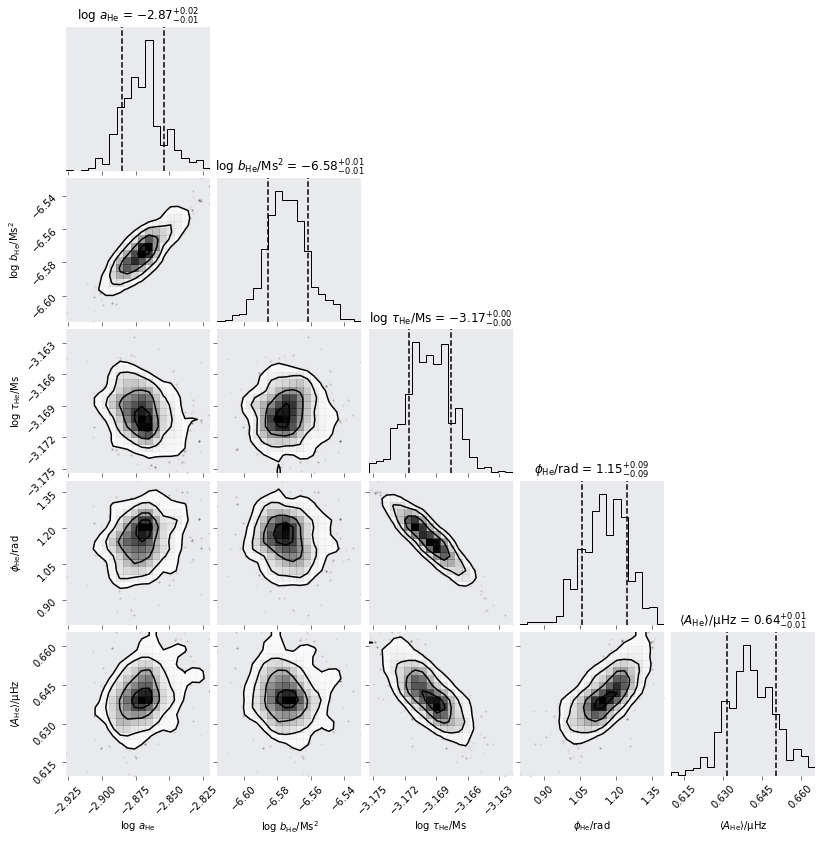

In [18]:
ast.plot_corner(data, var_names=['log_a_he', 'log_b_he', 'log_tau_he', 'phi_he', 'he_amplitude']);

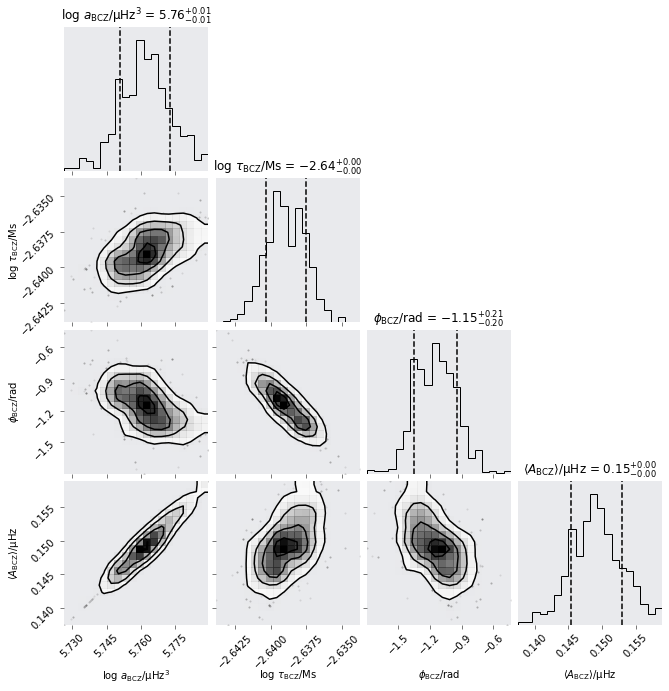

In [19]:
ast.plot_corner(data, var_names=['log_a_cz', 'log_tau_cz', 'phi_cz', 'cz_amplitude']);

Be careful when interpretting $\Delta\nu$ and $\epsilon$. These parameters are specific to this model and may be sensitive to the radial orders observed.

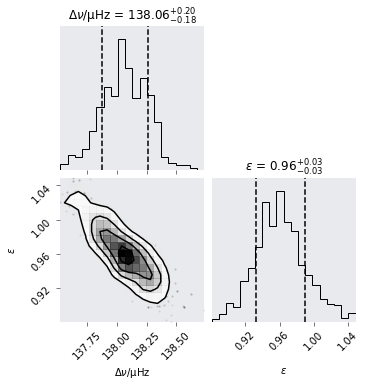

In [20]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon']);

In [21]:
import astropy.units as u

In [22]:
# Convert to physical quantity from Houdek and Gough (2007)
data.posterior["delta_he"] = np.sqrt(data.posterior["b_he"]/2)/2/np.pi
data.posterior["delta_he"].attrs["unit"] = str(u.megasecond)

In [23]:
from astropy.table import QTable

table = ast.get_table(data, dims=(), var_names=["a_he", "b_he", "tau_he", "a_cz", "tau_cz", "delta_he"], fmt="astropy")
table = QTable(table)  # <-- convert to quantity table
table

metric,a_he,b_he,tau_he,a_cz,tau_cz,delta_he
,,Ms2,Ms,uHz3,Ms,Ms
str4,float64,float64,float64,float64,float64,float64
mean,0.001351,2.668e-07,0.0006766,578260.0,0.0022966,5.813e-05
sd,4.9e-05,7.8e-09,3.3e-06,14850.0,7.3e-06,8.5e-07
16th,0.001304,2.595e-07,0.0006736,563290.0,0.0022891,5.733e-05
50th,0.001348,2.66e-07,0.0006768,577600.0,0.0022962,5.804e-05
84th,0.001399,2.743e-07,0.0006799,592890.0,0.0023041,5.894e-05


In [24]:
mean = table[table["metric"] == "mean"][0]
sd = table[table["metric"] == "sd"][0]

p16 = table[table["metric"] == "16th"][0]
p50 = table[table["metric"] == "50th"][0]
p84 = table[table["metric"] == "84th"][0]

Approx acoustic depth of the helium-II ionization zone

In [25]:
dp = 1
col = "tau_he"
unit = u.s  # <-- convert to seconds
med = p50[col].to(unit)
em = med - p16[col].to(unit)
ep = p84[col].to(unit) - med
print(f"{col} = {med:.{dp}f} (- {em:.{dp}f}) (+ {ep:.{dp}f})")

tau_he = 676.8 s (- 3.2 s) (+ 3.1 s)


Approx acoustic width of the helium-II ionization zone

In [26]:
dp = 2
col = "delta_he"
unit = u.s
med = p50[col].to(unit)
em = med - p16[col].to(unit)
ep = p84[col].to(unit) - med
print(f"{col} = {med:.{dp}f} (- {em:.{dp}f}) (+ {ep:.{dp}f})")

delta_he = 58.04 s (- 0.71 s) (+ 0.90 s)


Acoustic depth of the base of the convective zone

In [27]:
dp = 1
col = "tau_cz"
unit = u.s
med = p50[col].to(unit)
em = med - p16[col].to(unit)
ep = p84[col].to(unit) - med
print(f"{col} = {med:.{dp}f} (- {em:.{dp}f}) (+ {ep:.{dp}f})")

tau_cz = 2296.2 s (- 7.1 s) (+ 7.9 s)
